In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd /home/mabitbol/GBT-S140/analysis/

/home/mabitbol/GBT-S140/analysis


In [3]:
import foregrounds as fg
from scipy.optimize import curve_fit
import emcee
import corner

In [4]:
from __future__ import unicode_literals

figsize(16, 10)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
    
rcParams['xtick.labelsize'] = 20
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.pad'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1

rcParams['ytick.labelsize'] = 20
rcParams['ytick.major.size'] = 10
rcParams['ytick.major.width'] = 1
rcParams['ytick.major.pad'] = 10
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.width'] = 1

rcParams['legend.fontsize'] = 24
rcParams['legend.borderaxespad'] = 1

rcParams['axes.labelsize'] = 24
rcParams['axes.titlesize'] = 24

In [5]:
fdg = np.loadtxt('/home/mabitbol/GBT-S140/externaldata/fd_G107_wim.dat')

In [6]:
cfs = fdg[:, 0] * 1.e9
mask = cfs < 4.e12
cfs = cfs[mask]
cjys = fdg[:, 1][mask]
cerrs = fdg[:, 2][mask]
cfit = fdg[:, 3][mask]
crem = fdg[:, 4][mask]
cremerr = fdg[:, 5][mask]

In [7]:
freqs = np.logspace(8, 13, 2000)
nu = freqs*1.e-9

In [8]:
beam = pi*(1.*pi/180.)**2
beam2 = pi*((0.16/60.)*pi/180.)**2

In [9]:
nfreqs = np.array([4.575, 5.625, 6.125]) * 1.e9
newdata = np.array([ 17.05, 17.66, 19.5])
nerrs = newdata * 0.1

In [10]:
bigfs = np.concatenate([cfs, nfreqs])
bigdata = np.concatenate([cjys, newdata])
bigerrs = np.concatenate([cerrs, nerrs])

In [11]:
def signal(freqs, EM, Asd, nup, Ad, Bd, Td, Acmb):
    fffit = fg.freefreep(freqs, EM=EM, Te=8000)
    amefit = fg.ame(freqs, Asd=Asd, nup=nup) 
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=Td)
    ccmb = fg.cmb(freqs, A=Acmb)
    return (fffit + dustfit + amefit + ccmb) * beam

In [12]:
def signal2(freqs, EM1, EM2, abeam, Ad, Bd, Td, Acmb):
    fffit = fg.freefreep(freqs, EM=EM1, Te=8000) * beam
    fffit2 = fg.freefreep(freqs, EM=EM2, Te=8000) * abeam
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=Td) * beam
    ccmb = fg.cmb(freqs, A=Acmb) * beam
    return fffit + fffit2 + dustfit + ccmb

In [13]:
pn = np.array([100., 1.e-3, 20.e9, 1.e-4, 2., 20., 30.e-6])
x = curve_fit(signal, bigfs, bigdata, p0=pn, sigma=bigerrs, absolute_sigma=True)
pfit3 = x[0]

In [14]:
pn2 = np.array([100., 1.e6, beam2, 1.e-4, 2., 20., 30e-6])
y = curve_fit(signal2, bigfs, bigdata, p0=pn2, sigma=bigerrs, absolute_sigma=True)
pfit4 = y[0]

In [15]:
print "EM, Asd, nup, Ad, Bd, Td, Acmb"
print pfit3

EM, Asd, nup, Ad, Bd, Td, Acmb
[  2.02037544e+02   1.18348842e-03   3.01935269e+10   7.46212184e-04
   1.90933921e+00   1.96199812e+01   8.13262751e-05]


In [16]:
print "EM1, EM2, abeam, Ad, Bd, Td, Acmb"
print pfit4

EM1, EM2, abeam, Ad, Bd, Td, Acmb
[  1.36611687e+02   5.88905085e+06   1.40439321e-08   6.50914076e-04
   2.31404125e+00   1.77924224e+01   1.67130282e-04]


In [17]:
np.sqrt(pfit4[2] / pi) * 180. / pi * 60.

0.22984936399161643

In [24]:
figsize(8, 6)

In [81]:
print "EM1, EM2, abeam, Ad, Bd, Td, Acmb"
map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples1, [16, 50, 84], axis=0)))

EM1, EM2, abeam, Ad, Bd, Td, Acmb


[(170.28046393884864, 22.259617745868951, 32.353735623316226),
 (922341498.72484004, 1144707503.0336084, 443321426.14568198),
 (4.4023984846823064e-10, 3.9507503401280828e-10, 2.1953018383233749e-10),
 (0.00077591621146938278, 0.0001161966981070658, 0.0001160600586983658),
 (1.5656073380767876, 0.37429378863517004, 0.3613845659294439),
 (21.752960524390851, 3.6893297997590082, 2.6134979187460203),
 (-0.00010840401021492015, 8.2342054262492955e-05, 0.00011127283909473254)]

In [82]:
def lnprior2(theta):
    EM1, EM2, abeam, Ad, Bd, Td, Acmb = theta
    if EM1 < 0 or EM1 > 1e4:
        return np.inf
    if EM2 < 1e4 or EM2 > 1e11:
        return np.inf
    if abeam < 0 or abeam > 1e-5:
        return np.inf
    if Ad < 0 or Ad > 10:
        return np.inf
    if Bd < 0 or Bd > 10:
        return np.inf
    if Td < 1 or Td > 100:
        return np.inf
    if np.abs(Acmb) > 10:
        return np.inf
    return 0.

In [83]:
def lnprob2(theta, x, y, yerr):
    lp = lnprior2(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike2(theta, x, y, yerr)

In [84]:
def lnlike2(theta, x, y, yerr):
    EM1, EM2, abeam, Ad, Bd, Td, Acmb = theta
    fffit = fg.freefreep(x, EM=EM1, Te=8000.) * beam
    fffit2 = fg.freefreep(x, EM=EM2, Te=8000.) * abeam
    dustfit = fg.thermal_dust(x, Ad=Ad, Bd=Bd, Td=Td) * beam
    ccmb = fg.cmb(x, A=Acmb) * beam
    model = fffit + fffit2 + dustfit + ccmb
    return -0.5 * np.sum((y-model)**2 / (yerr**2))

In [85]:
newbest = np.percentile(samples1, 50, axis=0)

In [50]:
ndim, nwalkers = 7, 128
pos = [pfit4 * (1. + 1.e-3*np.random.randn(ndim)) for i in range(nwalkers)]

In [86]:
ndim, nwalkers = 7, 128
pos = [newbest * (1. + 1.e-3*np.random.randn(ndim)) for i in range(nwalkers)]

In [87]:
sampler1 = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, args=(bigfs, bigdata, bigerrs))

In [88]:
sampler1.run_mcmc(pos, 2**16);

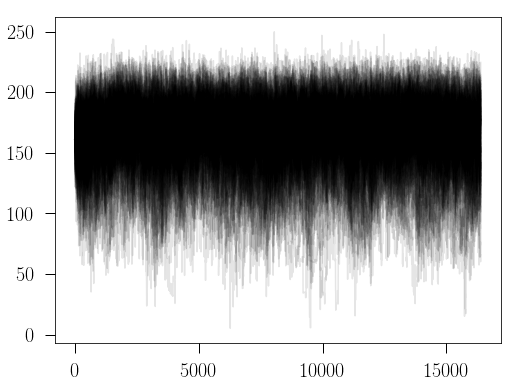

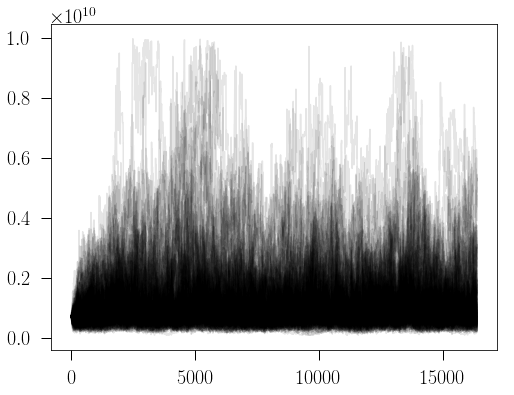

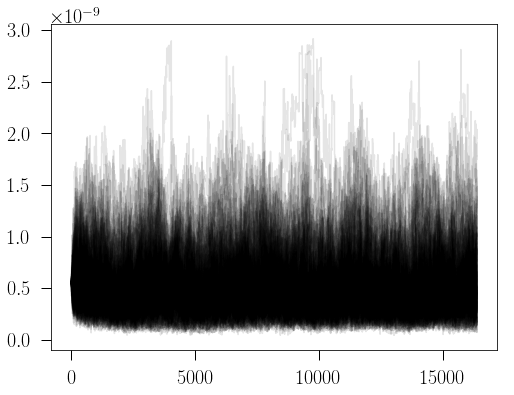

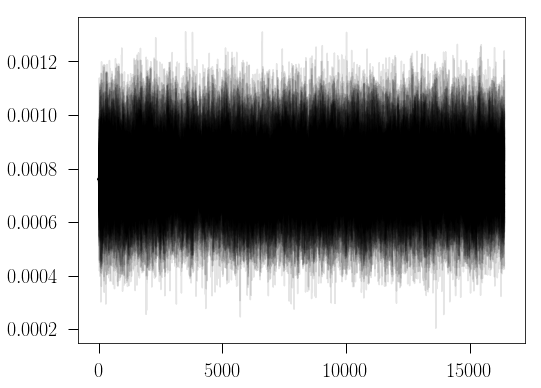

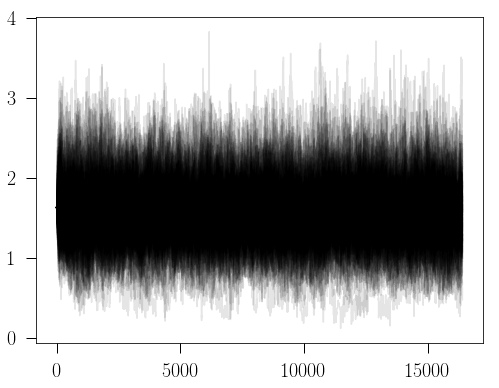

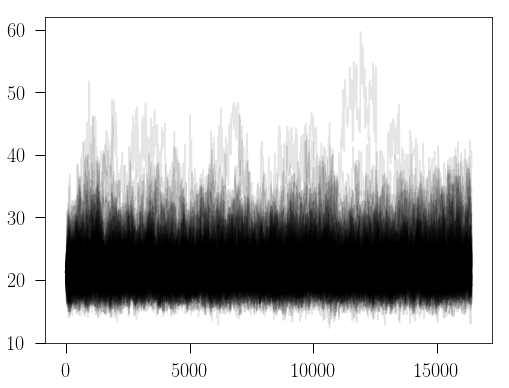

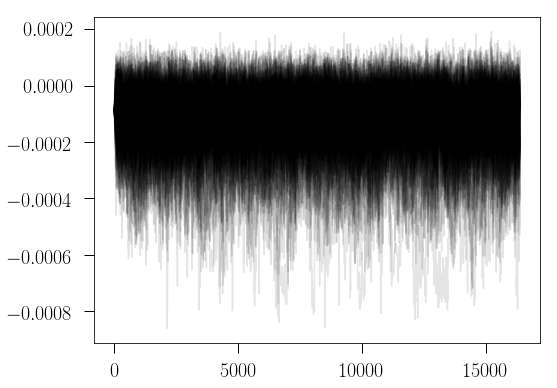

In [76]:
for k in range(ndim):
    figure()
    plot(sampler1.chain[:,:,k].T, color='k', alpha=0.1);

In [77]:
samples1 = sampler1.chain[:, 5000:, :].reshape((-1, ndim))

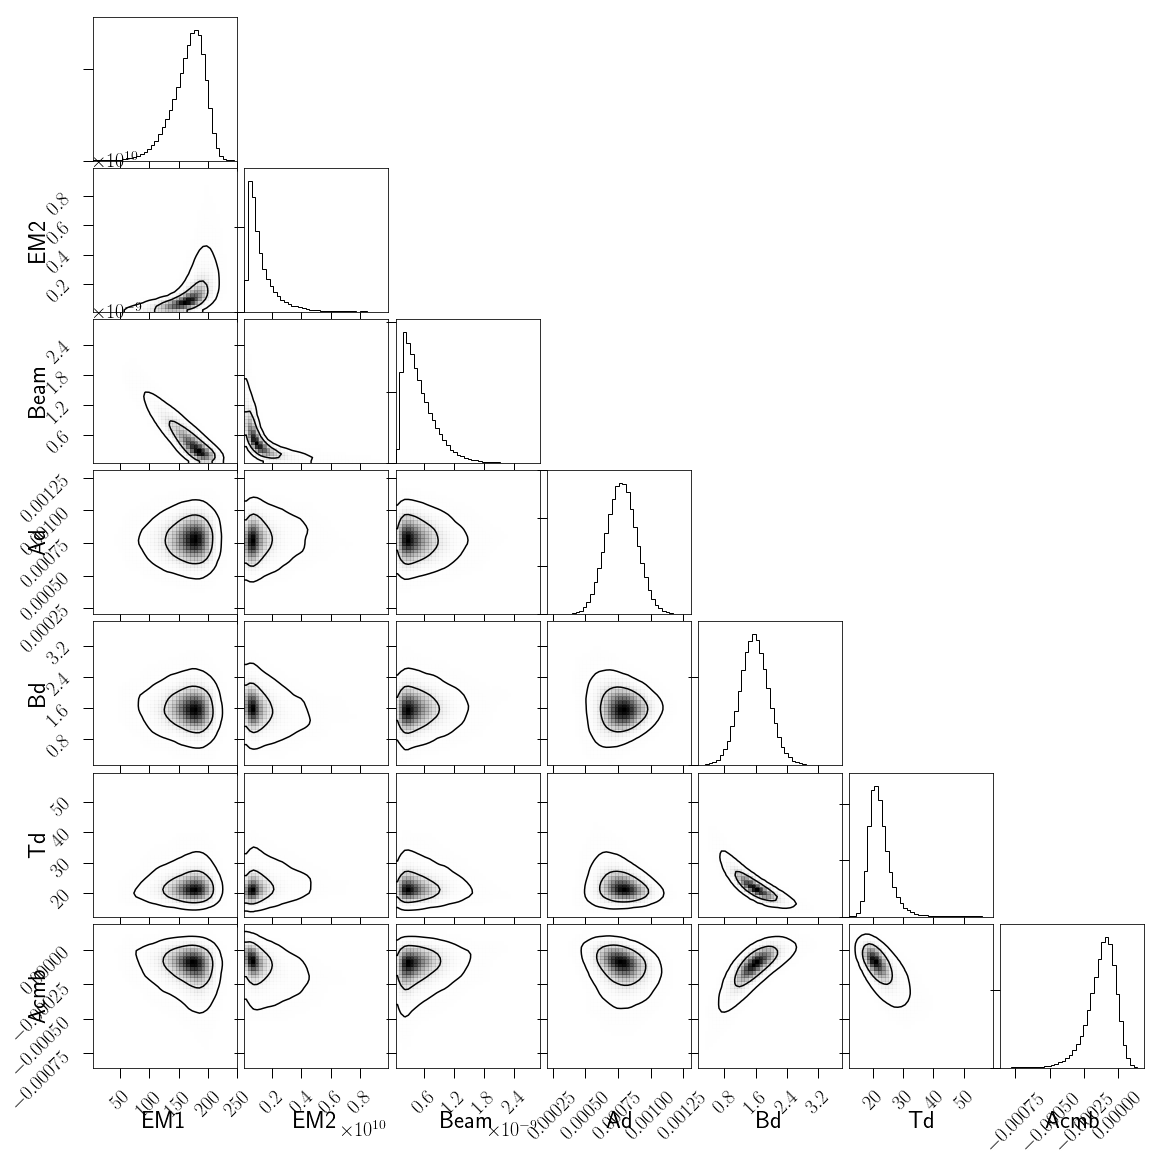

In [78]:
fig = corner.corner(samples1, plot_datapoints=False, bins=40, levels=[0.68,0.95], smooth=1.,\
                    labels=["EM1", "EM2", "Beam", "Ad", "Bd", "Td", "Acmb"])
#savefig('/home/mabitbol/GBT-S140/notebooks/UCHII_posterior')

In [79]:
print "EM1, EM2, abeam, Ad, Bd, Td, Acmb"
print pfit4
map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples1, [16, 50, 84], axis=0)))

EM1, EM2, abeam, Ad, Bd, Td, Acmb
[  1.36611687e+02   5.88905085e+06   1.40439321e-08   6.50914076e-04
   2.31404125e+00   1.77924224e+01   1.67130282e-04]


[(170.28046393884864, 22.259617745868951, 32.353735623316226),
 (922341498.72484004, 1144707503.0336084, 443321426.14568198),
 (4.4023984846823064e-10, 3.9507503401280828e-10, 2.1953018383233749e-10),
 (0.00077591621146938278, 0.0001161966981070658, 0.0001160600586983658),
 (1.5656073380767876, 0.37429378863517004, 0.3613845659294439),
 (21.752960524390851, 3.6893297997590082, 2.6134979187460203),
 (-0.00010840401021492015, 8.2342054262492955e-05, 0.00011127283909473254)]

In [80]:
np.sqrt(np.array([5.0465435704712113e-10, 8.8948457380303142e-10, 2.6431245527012805e-10]) / pi) * 180. / pi * 60. * 60.

array([ 2.61425056,  3.47071863,  1.8919472 ])

In [38]:
#arcseconds...

In [52]:
def lnprior(theta):
    EM, Asd, nup, Ad, Bd, Td, Acmb = theta
    if EM < 0 or EM > 1e9:
        return np.inf
    if Asd < 0 or Asd > 1e3:
        return np.inf
    if nup < 1e9 or nup > 1e11:
        return np.inf
    if Ad < 0 or Ad > 1e3:
        return np.inf
    if Bd < 0 or Bd > 100:
        return np.inf
    if Td < 0 or Td > 1000:
        return np.inf
    if np.abs(Acmb) > 1e3:
        return np.inf
    return 0.

In [53]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [54]:
def lnlike(theta, x, y, yerr):
    EM, Asd, nup, Ad, Bd, Td, Acmb = theta
    fffit = fg.freefreep(x, EM=EM, Te=8000.)
    dustfit = fg.thermal_dust(x, Ad=Ad, Bd=Bd, Td=Td)
    amefit = fg.ame(x, Asd=Asd, nup=nup) 
    ccmb = fg.cmb(x, A=Acmb)
    model = (fffit + dustfit + amefit + ccmb) * beam
    return -0.5 * (np.sum((y - model)**2. * yerr**-2.))

In [55]:
ndim, nwalkers = 7, 64
pos = [pfit3 * (1. + 1.e-2*np.random.randn(ndim)) for i in range(nwalkers)]

In [56]:
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(bigfs, bigdata, bigerrs))

In [57]:
sampler2.run_mcmc(pos, 2**12);

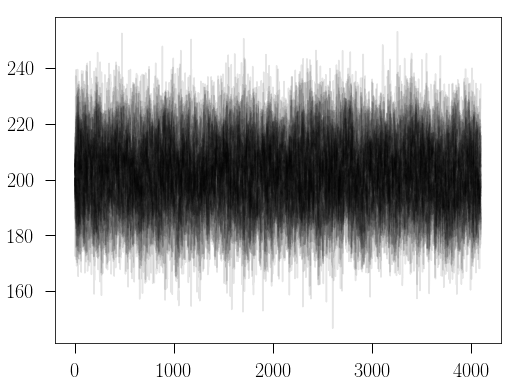

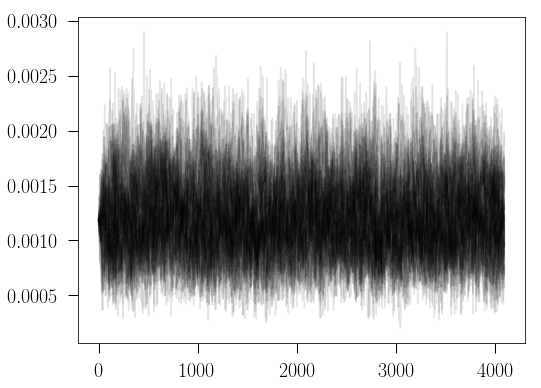

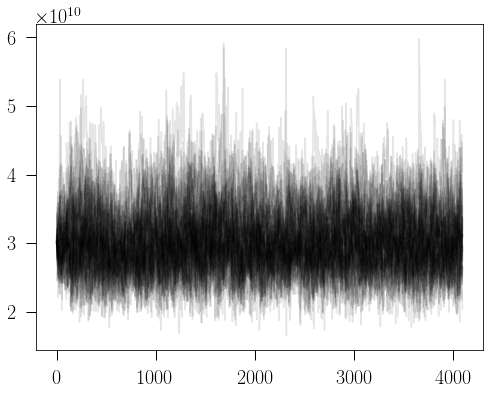

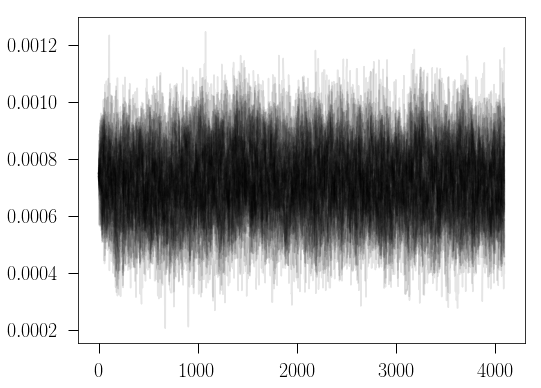

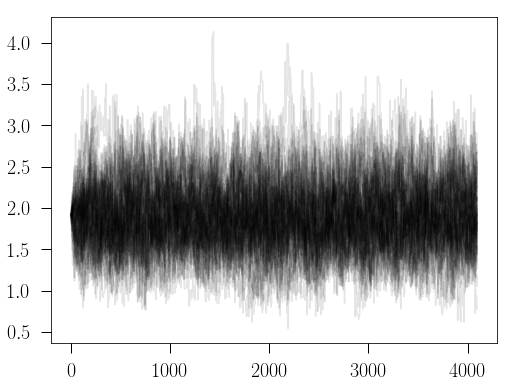

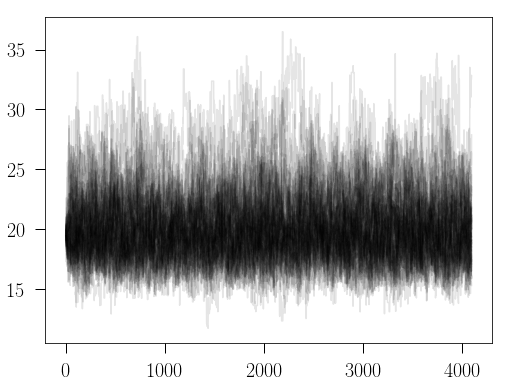

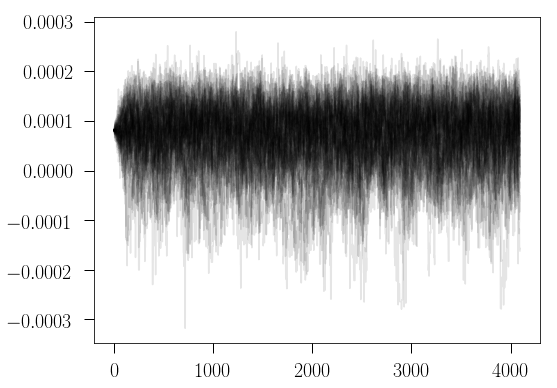

In [58]:
for k in range(ndim):
    figure()
    plot(sampler2.chain[:,:,k].T, color='k', alpha=0.1);

In [59]:
samples2 = sampler2.chain[:, 1000:, :].reshape((-1, ndim))

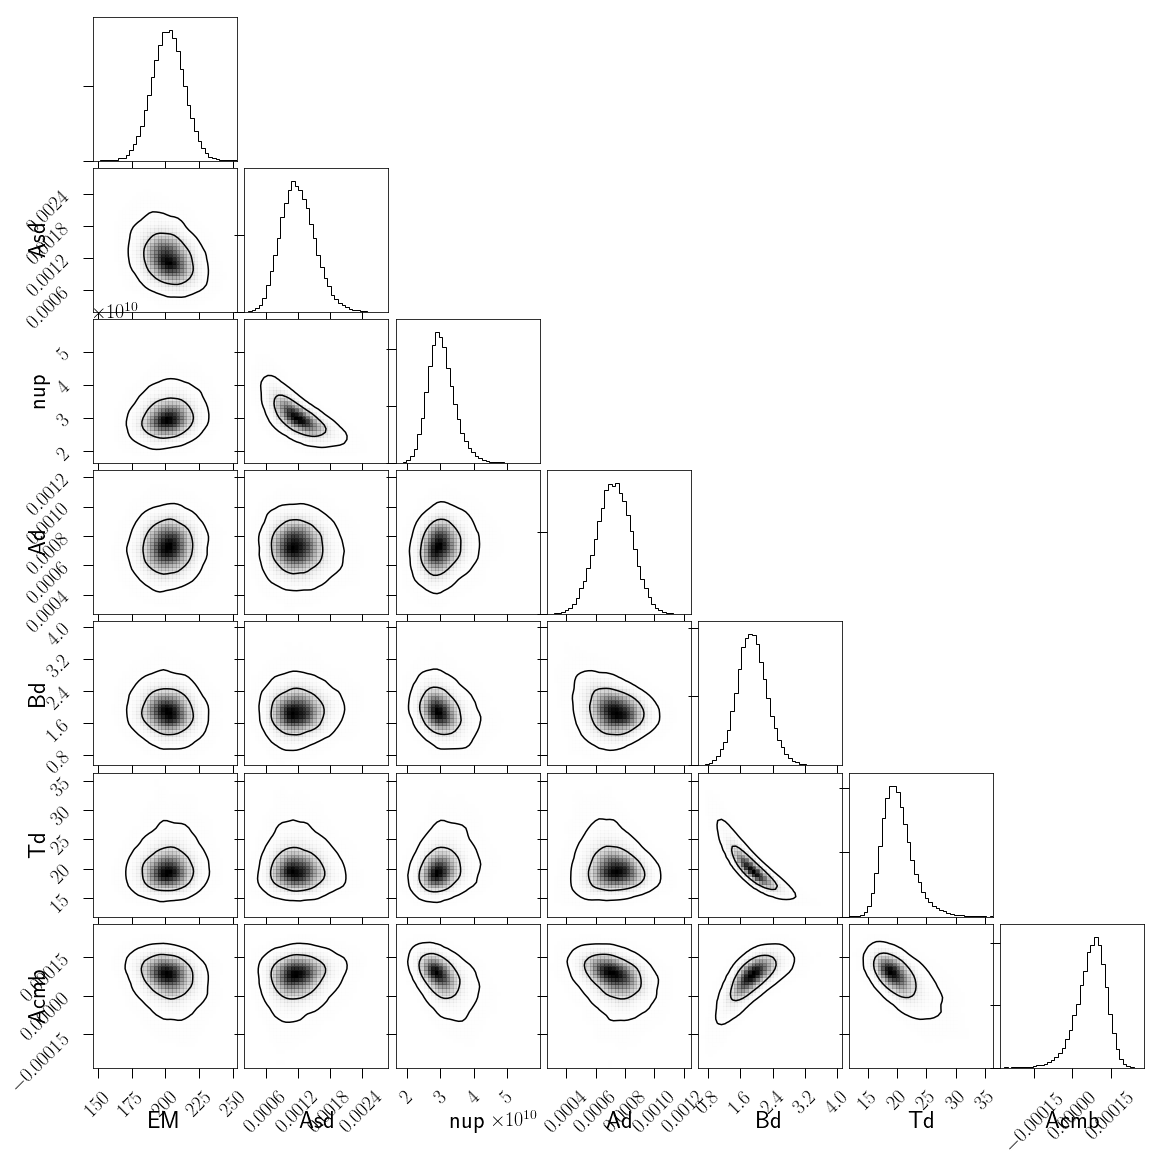

In [65]:
fig = corner.corner(samples2, plot_datapoints=False, bins=40, levels=[0.68,0.95], smooth=1.,\
                    labels=["EM", "Asd", "nup", "Ad", "Bd", "Td", "Acmb"])
#savefig('/home/mabitbol/GBT-S140/notebooks/spinningdust_posterior')

In [61]:
print "EM, Asd, nup, Ad, Bd, Td, Acmb"
print pfit3
map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples2, [16, 50, 84], axis=0)))

EM, Asd, nup, Ad, Bd, Td, Acmb
[  2.02037544e+02   1.18348842e-03   3.01935269e+10   7.46212184e-04
   1.90933921e+00   1.96199812e+01   8.13262751e-05]


[(201.84903743790238, 11.758341864202862, 11.923542833004149),
 (0.0011872618613695529, 0.00033587461409279886, 0.00029750998611455433),
 (29954515638.335735, 4260701090.6748009, 3512732477.7545013),
 (0.00072439175152493832, 0.00011848512781053309, 0.00011917483185795122),
 (1.8838449160686825, 0.38090447869559574, 0.35377475437554096),
 (19.806967863855736, 2.797380427553712, 2.1486194756040007),
 (7.7548567887783927e-05, 4.9240203275031284e-05, 6.2414074343178724e-05)]